<a href="https://colab.research.google.com/github/omarrajaa/AI-4-Climate-Change-Identifying-plants-disease/blob/main/AI_4_Climate_Change_(Identifying_plants_disease).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Identifying plants disease project </center>

first we need to import libraries  and put random state

In [ ]:
#libraties
!pip install gradio
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import os
import gradio as gr
#random state
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## **1. Download and Read data**

### 1.1 download

In [ ]:
!wget 'https://docs.google.com/uc?export=download&id=1uoovX3TrkZrOIS3ARsWZEXEMCORWW1RK&confirm=t'
os.rename('uc?export=download&id=1uoovX3TrkZrOIS3ARsWZEXEMCORWW1RK&confirm=t', 'data_of_plants_leaf_diseases.zip')
!unzip data_of_plants_leaf_diseases.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_of_plants_leaf_diseases/Tomato__Target_Spot/3a2dbdb1-188c-4499-acff-1bcc3b377320___Com.G_TgS_FL 8206_newPixel25.JPG  
  inflating: data_of_plants_leaf_diseases/Tomato__Target_Spot/3a53fede-6ec6-4e6c-a19f-ad1324604ca8___Com.G_TgS_FL 8086_180deg.JPG  
  inflating: data_of_plants_leaf_diseases/Tomato__Target_Spot/3a53fede-6ec6-4e6c-a19f-ad1324604ca8___Com.G_TgS_FL 8086_flipTB.JPG  
  inflating: data_of_plants_leaf_diseases/Tomato__Target_Spot/3a53fede-6ec6-4e6c-a19f-ad1324604ca8___Com.G_TgS_FL 8086_new30degFlipLR.JPG  
  inflating: data_of_plants_leaf_diseases/Tomato__Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336.JPG  
  inflating: data_of_plants_leaf_diseases/Tomato__Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336_180deg.JPG  
  inflating: data_of_plants_leaf_diseases/Tomato__Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336_flipTB.JPG  
  inflating: data_of

### 1.2 read


In [ ]:
from pathlib import Path
import imghdr

img_link=list(Path("/content/data_of_plants_leaf_diseases").glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)
!rm -rf /content/data_of_plants_leaf_diseases/cotton__healthy/h420.webp

Total 27 pcs image delete from Dataset


In [ ]:
def read_dataset(path):  # path of data
    x = []  # images
    y = []  # labels

    # we will use os.listdir to read the contents of the folder
    labels = os.listdir(path)

    # iterate over the labels
    for label in labels:
        # we join the label to the path to get the path to the class folder which contains the images
        label_dir = os.path.join(path, label)

        # we will use os.listdir again to read the contents of the class folders (i.e., the images)
        images = os.listdir(label_dir)

        # iterate over the images
        for image in os.listdir(label_dir):
            # we join the image name to the path to get the path to the image
            image_path = os.path.join(
                label_dir, image
            ) 

            # append the image path and the label to the lists
            x.append(image_path)
            y.append(label)

    # return a dataframe with the image paths and labels
    return pd.DataFrame({"image": x, "label": y})


# read the data
data_df = read_dataset("data_of_plants_leaf_diseases")

In [ ]:
train_df , validation_df = model_selection.train_test_split(data_df,test_size= 0.2 , random_state=seed )

In [ ]:
label_to_index = dict(zip(pd.unique(train_df["label"]) , [item for item in range(35)]))
index_to_label = dict(zip([item for item in range(35)] ,pd.unique(train_df["label"])))

## **2. processing data (pipelines)**

In [ ]:
def image_to_resnet_tensor(x, y):
    # read the image from the path
    img = tf.io.read_file(x)
    # decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [224, 224])
    # normalize the image
    img = img/225.0
    return img, y

def label_to_one_hot(x, y):
  y = tf.one_hot(y, depth=len(pd.unique(train_df["label"])))
  return x, y


def image_augmentation(x, y):
    # randomly flip the image horizontally
    img = tf.image.random_flip_left_right(x)
    # randomly flip the image vertically
    img = tf.image.random_flip_up_down(img)
    # randomly change the brightness of the image
    img = tf.image.random_brightness(img, max_delta=0.2)
    # clip the image to be between 0 and 1
    img = tf.clip_by_value(img, 0, 1)
    return img, y

train_df["label"] = train_df["label"].map(label_to_index)
validation_df["label"] = validation_df["label"].map(label_to_index)

In [ ]:
def tf_dataset_creator(x, y, training=False):
    # create a tf.data.Dataset from the input output pairs
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    # map the image paths to tensors using the new resnet preprocessing function
    dataset = dataset.map(image_to_resnet_tensor)
    # map the labels to one-hot encoded vectors
    dataset = dataset.map(label_to_one_hot)
    # if training, apply image augmentation. Remember that we never apply image augmentation to the validation set
    if training:
        dataset = dataset.map(image_augmentation)
    # shuffle the dataset
    dataset = dataset.shuffle(1000)
    # batch the dataset
    dataset = dataset.batch(32)
    # auto tune data
    dataset = dataset.prefetch(tf.data.AUTOTUNE) 
    return dataset

train_dataset = tf_dataset_creator(train_df["image"], train_df["label"], training=True)
validation_dataset = tf_dataset_creator(validation_df["image"], validation_df["label"])

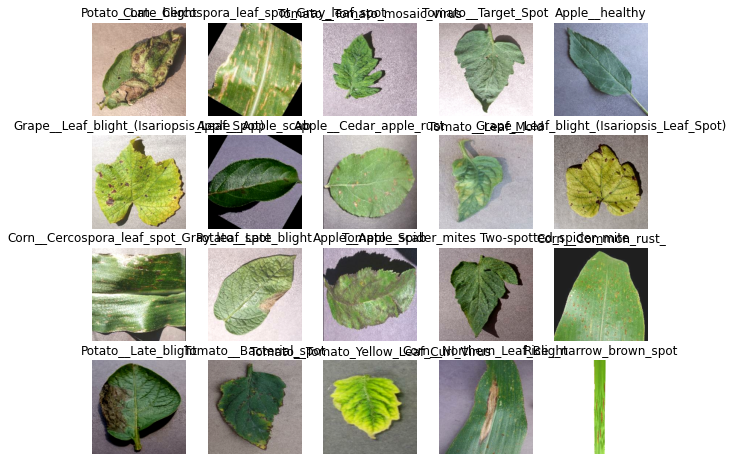

In [ ]:
for image, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image[i].numpy())
        plt.title(index_to_label[np.argmax(label[i].numpy())])
        plt.axis("off")

## **3.model**

### **3.1 model building**

In [ ]:
model_cnn = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding="same" ,input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(128, use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu"),

      tf.keras.layers.Dense(64, use_bias=False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu"),

      tf.keras.layers.Dense(len(pd.unique(train_df["label"])), activation='softmax')
    ])
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 128)     9728      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 108, 108, 64)      204864    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 32)        51232     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 25, 32)      

In [ ]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

h= model_cnn.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[early_stopping])

h

Epoch 1/10
1256/1256 [==============================] - 172s 131ms/step - loss: 1.3187 - accuracy: 0.6194 - val_loss: 1.3690 - val_accuracy: 0.5654
Epoch 2/10
1256/1256 [==============================] - 160s 126ms/step - loss: 0.6316 - accuracy: 0.7949 - val_loss: 0.8593 - val_accuracy: 0.7122
Epoch 3/10
1256/1256 [==============================] - 159s 125ms/step - loss: 0.4531 - accuracy: 0.8472 - val_loss: 0.8262 - val_accuracy: 0.7379
Epoch 4/10
1256/1256 [==============================] - 164s 129ms/step - loss: 0.3258 - accuracy: 0.8889 - val_loss: 0.6974 - val_accuracy: 0.7842
Epoch 5/10
1256/1256 [==============================] - 162s 127ms/step - loss: 0.2406 - accuracy: 0.9180 - val_loss: 0.3853 - val_accuracy: 0.8730
Epoch 6/10
1256/1256 [==============================] - 165s 130ms/step - loss: 0.1800 - accuracy: 0.9392 - val_loss: 0.5499 - val_accuracy: 0.8331
Epoch 7/10
1256/1256 [==============================] - 162s 127ms/step - loss: 0.1452 - accuracy: 0.9511 - val_

In [ ]:
plt.plot(h.history['accuracy'],'o')
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'],'o')
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### **3.2 save and load model**

In [ ]:
# to save model 
model_cnn.save("model.h5")

In [ ]:
# load it 
model_cnn = tf.keras.models.load_model('model.h5')

## **4.interface** 

In [ ]:
def classify_image(img):
  img = img.reshape((-1, 224, 224, 3))
  img = img/225.0
  prediction = model_cnn.predict(img)
  confidences = index_to_label[np.argmax(prediction)]
  return confidences

gr.Interface(
    fn=classify_image, 
    inputs=gr.inputs.Image(shape=(224, 224)),
    outputs=gr.inputs.Textbox(label="P D")
    ).launch(debug=True,share=True)